In [1]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path

if Path.cwd().name != "LightGlue":
    !git clone --quiet https://github.com/cvg/LightGlue/
    %cd LightGlue
    !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)
images = Path("data")

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

# extractor = SuperPoint(max_num_keypoints=256).eval().to(device)  # load the extractor
# matcher = LightGlue(features="superpoint").eval().to(device)

In [3]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

# from siamese.trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [5]:
def convert_to_displayable_image(image):
    # Convert from tensor to NumPy if needed
    if torch.is_tensor(image):
        image = image.cpu().detach().numpy()
    
    # If image is float32, scale to [0, 255] and convert to uint8
    if image.dtype == np.float32:
        image = (image * 255).astype(np.uint8)
    
    # If image is in channels-first format, convert to channels-last
    if image.ndim == 3 and image.shape[0] in [1, 3]:
        image = image.transpose(1, 2, 0)  # Convert CxHxW to HxWxC

    return Image.fromarray(image)

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
import matplotlib.colors as mcolors
import numpy as np

%matplotlib inline
# Can only be used with a display
# %matplotlib notebook
# matplotlib.use('TkAgg')

def show_matched_keypoints(image1, image2, good_kpts1, good_kpts2, bad_kpts1, bad_kpts2):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Convert images to displayable format
    image1_np = image1.cpu().numpy().transpose(1, 2, 0)
    image2_np = image2.cpu().numpy().transpose(1, 2, 0)

    print(image1_np.shape)
    print(image2_np.shape)

    # Display original images
    axs[0].imshow(image1_np)
    axs[1].imshow(image2_np)

    # Overlay patches on images
    for i in range(len(good_kpts1)):
        x1, y1 = good_kpts1[i]
        x2, y2 = good_kpts2[i]
        color = 'lime'
        cir1 = patches.Circle((x1, y1), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        cir2 = patches.Circle((x2, y2), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        axs[0].add_patch(cir1)
        axs[1].add_patch(cir2)

        # Draw a line connecting the patches
        line = ConnectionPatch(xyA=(x1, y1), xyB=(x2, y2), coordsA='data', coordsB='data', axesA=axs[0], axesB=axs[1], color=color, alpha=0.5, linewidth=1.0)
        axs[1].add_artist(line)

    for i in range(len(bad_kpts1)):
        x1, y1 = bad_kpts1[i]
        x2, y2 = bad_kpts2[i]
        color = 'red'
        cir1 = patches.Circle((x1, y1), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        cir2 = patches.Circle((x2, y2), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        axs[0].add_patch(cir1)
        axs[1].add_patch(cir2)

        # Draw a line connecting the patches
        line = ConnectionPatch(xyA=(x1, y1), xyB=(x2, y2), coordsA='data', coordsB='data', axesA=axs[0], axesB=axs[1], color=color, alpha=0.5, linewidth=1.0)
        axs[1].add_artist(line)

    plt.savefig("cos_mind_slice_match.png")
    plt.show()


In [7]:
from sklearn.metrics.pairwise import cosine_similarity

def find_top_matches(patches1, patches2, kpts1, kpts2, embeddings1, embeddings2, sim_threshold):
    # Convert embeddings to NumPy arrays for efficient computation
    embeddings1_array = np.array(embeddings1)
    embeddings2_array = np.array(embeddings2)

    # Normalize the embeddings
    embeddings1_array = embeddings1_array / np.linalg.norm(embeddings1_array, axis=1, keepdims=True)
    embeddings2_array = embeddings2_array / np.linalg.norm(embeddings2_array, axis=1, keepdims=True)


    # Initialize lists to store matches
    good_match_similarities, bad_match_similarities = [], []
    good_kpts1, good_kpts2, good_patches1, good_patches2 = [], [], [], []
    bad_kpts1, bad_kpts2, bad_patches1, bad_patches2 = [], [], [], []

    # print(embeddings1_array.shape)

    # Computer pairwise cos distance
    similarities = cosine_similarity(embeddings1_array, embeddings2_array)

    # print(similarities)

    
    # Find the top K matches for each embedding in embeddings1
    sorted_indices = np.argsort(similarities, axis=1)[:, ::-1]

    # print(sorted_indices)

    for i, (sorted_idx, emb_similarities) in enumerate(zip(sorted_indices, similarities)):
        # Apply Lowe's ratio test
        if len(sorted_idx) >= 2 and emb_similarities[sorted_idx[0]] > sim_threshold:
            ratio = emb_similarities[sorted_idx[1]] / emb_similarities[sorted_idx[0]]
            if emb_similarities[sorted_idx[0]] > sim_threshold:
                if ratio < 0.99:
                # if True:
                    # Good match
                    good_match_similarities.append(emb_similarities[sorted_idx[0]])
                    good_kpts1.append(kpts1[i])
                    good_kpts2.append(kpts2[sorted_idx[0]])
                    good_patches1.append(patches1[i])
                    good_patches2.append(patches2[sorted_idx[0]])
                else:
                    # Bad match
                    bad_match_similarities.append(emb_similarities[sorted_idx[0]])
                    bad_kpts1.append(kpts1[i])
                    bad_kpts2.append(kpts2[sorted_idx[0]])
                    bad_patches1.append(patches1[i])
                    bad_patches2.append(patches2[sorted_idx[0]])

    return good_match_similarities, bad_match_similarities, good_kpts1, good_kpts2, bad_kpts1, bad_kpts2, good_patches1, good_patches2, bad_patches1, bad_patches2


In [8]:
import torch
from PIL import Image
from torchvision.transforms import Resize, ToTensor

def isolate_green_and_mask_image(image_path, mask_path, long_side, device):
    
    # Load the images
    image = load_path_for_pytorch(image_path, long_side, force_scale=True)
    mask = load_path_for_pytorch(mask_path, long_side, force_scale=True)

    # Convert to tensor
    # to_tensor = ToTensor()
    image = image.to(device)
    mask = mask.to(device)

    # Isolate the green channel and create a binary mask
    # Assuming green regions have higher green values compared to red and blue
    green_channel = mask[1, :, :]
    red_channel = mask[0, :, :]
    blue_channel = mask[2, :, :]
    binary_mask = (green_channel > red_channel) & (green_channel > blue_channel)
    binary_mask = binary_mask.float()

    kernel_size = 11  # This corresponds to reducing the ROI by 5 pixels in each direction
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply erosion to reduce the ROI
    eroded_mask = cv2.erode(binary_mask.cpu().numpy(), kernel, iterations=1)

    # Apply the mask
    masked_image = image * torch.from_numpy(eroded_mask).unsqueeze(0).to(device)

    return masked_image, binary_mask

In [9]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
from imageio import imread
import numpy as np

def load_path_for_pytorch(path, max_side=1000, force_scale=False, verbose=True):

    com_f = max

    x = imread(path)
    s = x.shape

    x = x/255.#-0.5
    xt = x.copy()
    
    if len(s) < 3:
        x = np.stack([x,x,x],2)

    if x.shape[2] > 3:
        x = x[:,:,:3]

    x = x.astype(np.float32)
    x = torch.from_numpy(x).contiguous().permute(2,0,1).contiguous()


    if (com_f(s[:2])>max_side and max_side>0) or force_scale:


        fac = float(max_side)/com_f(s[:2])
        x = F.interpolate(x.unsqueeze(0),( int(s[0]*fac), int(s[1]*fac) ), mode='bilinear', align_corners=False)[0]
        so = s
        s = x.shape

    return x

In [10]:
from sklearn.cluster import DBSCAN
import numpy as np

def cluster_keypoints_dbscan(kpts2, eps=2, min_samples=2):
    """
    Cluster keypoints in image 2 using DBSCAN.

    Parameters:
    - kpts2: numpy array of keypoints in image 2 of shape (N2, 2).
    - eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    - min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.

    Returns:
    - clustered_kpts: numpy array of the centroid of each cluster.
    """

    # Run DBSCAN
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(kpts2)
    
    clustered_kpts = []
    for label in set(clustering.labels_):
        if label == -1:
            # Skip noise points
            continue
        # Find the centroid of each cluster
        cluster_points = kpts2[clustering.labels_ == label]
        centroid = cluster_points.mean(axis=0)
        clustered_kpts.append(centroid)

    return np.array(clustered_kpts)

# Assuming kpts2 is a numpy array containing the keypoints from image 2
# Example usage:
# clustered_kpts2 = cluster_keypoints_dbscan(kpts2.numpy(), eps=5, min_samples=3)

In [11]:
def filter_one_to_one_matches(matches):
    # Sort matches based on score so that higher scores come first
    matches.sort(key=lambda x: x[2], reverse=True)
    
    match_index1 = set()
    match_index2 = set()
    filtered_matches = []
    
    for index1, index2, score in matches:
        # If neither index1 nor index2 have been used yet, add the match
        if index1 not in match_index1 and index2 not in match_index2:
            filtered_matches.append((index1, index2, score))
            match_index1.add(index1)
            match_index2.add(index2)
    
    return filtered_matches

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import cv2

# Function to get embeddings for a list of patches
def get_embeddings(patches):
    embeddings = []
    # print(patches)
    for patch in patches:
        patch_processed = preprocess_image(patch).unsqueeze(0).to(device)  # Add batch dimension
        with torch.no_grad():
            embedding = model.get_embedding(patch_processed)
        embeddings.append(embedding.cpu().numpy())
    return np.vstack(embeddings)


def extract_and_match_patches(image1, kpts1, image2, extractor, device, patch_size=64):
    #Not used anymore, doesn't affect results if ratio test is used
    sim_threshold = 0.95
    
    # Preprocess and extract patches from both images
    image1 = image1.to(device)
    image2 = image2.to(device)

    # extractor = SuperPoint(max_num_keypoints=None).eval().to(device)
    
    # feats2 = extractor.extract(image2)
    # feats2 = rbd(feats2)
    # kpts2 = feats2["keypoints"]

    kpts2 = kpts1

    print(len(kpts2))

    # Example: Creating the initial list of matches with similarity scores
    # matches = [(i, j, score) for i, j, score in zip(range(len(good_kpts1)), range(len(good_kpts2)), good_match_sims)]
    
    # Filter for one-to-one matches
    # one_to_one_matches = filter_one_to_one_matches(matches)
    
    # Extracting the filtered keypoints and their scores
    # filtered_good_kpts1 = [good_kpts1[i] for i, _, _ in one_to_one_matches]
    # filtered_good_kpts2 = [good_kpts2[j] for _, j, _ in one_to_one_matches]
    # filtered_scores = [score for _, _, score in one_to_one_matches]

    # all_matches = len(filtered_good_kpts1)
    # print(f"All Matches: {all_matches}")

    # patches1, filtered_good_kpts1 = extract_patches(image1.cpu().numpy(), filtered_good_kpts1, size=patch_size)
    # patches2, filtered_good_kpts2 = extract_patches(image2.cpu().numpy(), filtered_good_kpts2, size=patch_size)
    
    # # print(f"All Matches (within threshold): {len(filtered_top_matches)}")
    # good_good_kpts1, good_good_kpts2, good_good_distances, bad_good_kpts1, bad_good_kpts2, bad_good_distances, similar_patches_count = extract_good_and_bad_matches(filtered_good_kpts1, filtered_good_kpts2, filtered_scores)
    # print(f"TPs: {len(good_good_kpts1)}")
    # print(f"FPs: {len(bad_good_kpts1)}")
    # print(f"TPR: {len(good_good_kpts1)/all_matches*100}%")
    # print(f"FPR: {len(bad_good_kpts1)/all_matches*100}%")
    # # print(f"Percentage of Good Matches: {(len(good_good_kpts1)/len(good_kpts1))*100}%")
    # show_matched_keypoints(image1, image2, good_good_kpts1, good_good_kpts2, bad_good_kpts1, bad_good_kpts2)
    # return kpts1, kpts2, good_good_kpts1, good_good_kpts2, good_good_distances, bad_good_kpts1, bad_good_kpts2, bad_good_distances

def extract_good_and_bad_matches(good_kpts1, good_kpts2, good_distances, margin=4):
    # Convert keypoints lists to NumPy arrays for efficient computation
    good_kpts1_array = np.array(good_kpts1)
    good_kpts2_array = np.array(good_kpts2)

    # Compute the absolute differences between keypoints
    diff = np.abs(good_kpts1_array - good_kpts2_array)

    # Identify good matches based on the margin
    good_matches_mask = np.all(diff <= margin, axis=1)

    # Split the keypoints, patches, and distances based on the good matches mask
    good_good_kpts1 = good_kpts1_array[good_matches_mask].tolist()
    good_good_kpts2 = good_kpts2_array[good_matches_mask].tolist()
    good_good_distances = np.array(good_distances)[good_matches_mask].tolist()

    bad_good_kpts1 = good_kpts1_array[~good_matches_mask].tolist()
    bad_good_kpts2 = good_kpts2_array[~good_matches_mask].tolist()
    bad_good_distances = np.array(good_distances)[~good_matches_mask].tolist()

    count = np.sum(good_matches_mask)

    return good_good_kpts1, good_good_kpts2, good_good_distances, bad_good_kpts1, bad_good_kpts2, bad_good_distances, count


def preprocess_image(image):
    # Implement any preprocessing steps (resizing, normalization, etc.)
    transform = transforms.Compose([
        transforms.ToTensor(),  # Converts image to PyTorch tensor in CxHxW format
        transforms.Normalize(mean=(0), std=(1))  # Normalize the image
    ])
    image = transform(image).to(device)
    return image

long_side = 192

image1 = load_path_for_pytorch("data/mr_us/Case096/t2/035.png", long_side,force_scale=True).to(device)
image2 = load_path_for_pytorch("data/mr_us/Case096/us/035.png", long_side,force_scale=True).to(device)

masked_image1, binary_mask = isolate_green_and_mask_image(images/"mr_us/Case096/t2/035.png", images/"mr_us/Case096/us_mask.png", long_side, device)

# plt.imshow(masked_image1.cpu().numpy().transpose(1,2,0))

extractor = SuperPoint(max_num_keypoints=200).eval().to(device)
# image1 = image1.to(device)
feats1 = extractor.extract(masked_image1)
feats1 = rbd(feats1)
kpts1 = feats1["keypoints"]
extract_and_match_patches(image1, kpts1, image2, extractor, device)
# kpts1, kpts2, good_kpts1, good_kpts2, good_distances, bad_kpts1, bad_kpts2, bad_distances = extract_and_match_patches(image1, kpts1, image2, extractor, device)

/tmp/ipykernel_16099/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


200


In [25]:
import numpy as np
from scipy.spatial.distance import cdist
import nibabel as nib

def load_mind_descriptors(path_t2, path_us, slice_number):
    # Load MIND descriptors from NIfTI files
    mind_t2 = nib.load(path_t2).get_fdata()[..., slice_number, :]
    mind_us = nib.load(path_us).get_fdata()[..., slice_number, :]
    return mind_t2, mind_us

# def match_keypoints_with_mind(kpts1, kpts2, mind1, mind2, ratio_threshold=0.99):
#     # Assuming kpts1 and kpts2 are the coordinates of the keypoints in images 1 and 2 respectively
#     # and mind1 and mind2 are the corresponding MIND descriptors for the entire images.

#     # Convert keypoints to integer indices to index MIND descriptors
#     kpts1_indices = np.round(kpts1.cpu().numpy()).astype(int)
#     kpts2_indices = np.round(kpts2.cpu().numpy()).astype(int)

#     # Extract the MIND descriptors for the keypoints
#     mind1_kpts = mind1[kpts1_indices[:, 1], kpts1_indices[:, 0], :]
#     mind2_kpts = mind2[kpts2_indices[:, 1], kpts2_indices[:, 0], :]

#      # Calculate the full similarity matrix
#     similarities = cosine_similarity(mind1_kpts, mind2_kpts)  # Ensure this returns a full matrix
    
#     filtered_matches = []
#     filtered_similarities = []
    
#     for i, similarity_scores in enumerate(similarities):
#         # Sort the scores in descending order and pick the top two
#         sorted_indices = np.argsort(similarity_scores)[::-1]
#         best, second_best = similarity_scores[sorted_indices[0]], similarity_scores[sorted_indices[1]]
        
#         # Apply Lowe's ratio test adapted for similarities
#         if second_best/best < ratio_threshold:
#             filtered_matches.append((sorted_indices[0]))  # Keep the match index and its best match
#             filtered_similarities.append(best)
    
#     return np.array(filtered_matches), np.array(filtered_similarities)

def match_keypoints_with_mind(kpts1, kpts2, mind1, mind2):
    # Assuming kpts1 and kpts2 are the coordinates of the keypoints in images 1 and 2 respectively
    # and mind1 and mind2 are the corresponding MIND descriptors for the entire images.

    # Convert keypoints to integer indices to index MIND descriptors
    kpts1_indices = np.round(kpts1.cpu().numpy()).astype(int)
    kpts2_indices = np.round(kpts2.cpu().numpy()).astype(int)

    # Extract the MIND descriptors for the keypoints
    mind1_kpts = mind1[kpts1_indices[:, 1], kpts1_indices[:, 0], :]
    mind2_kpts = mind2[kpts2_indices[:, 1], kpts2_indices[:, 0], :]

    # Calculate the distances between MIND descriptors of keypoints in image 1 to all in image 2
    # distances = cdist(mind1_kpts, mind2_kpts, 'euclidean')
    similarities = cosine_similarity(mind1_kpts, mind2_kpts)

    # Find the closest match for each keypoint in image 1 to those in image 2
    matches = np.argmax(similarities, axis=1)
    match_similarities = np.max(similarities, axis=1)

    return matches, match_similarities

slice_number = 39

image1 = load_path_for_pytorch(f"data/mr_us/Case067/t2/{slice_number:03}.png", long_side,force_scale=True).to(device)
image2 = load_path_for_pytorch(f"data/mr_us/Case067/us/{slice_number:03}.png", long_side,force_scale=True).to(device)

masked_image1, binary_mask = isolate_green_and_mask_image(images/f"mr_us/Case067/t2/{slice_number:03}.png", images/f"mr_us/Case096/us_mask.png", long_side, device)

# plt.imshow(masked_image1.cpu().numpy().transpose(1,2,0))

extractor = SuperPoint(max_num_keypoints=200).eval().to(device)
# image1 = image1.to(device)
feats1 = extractor.extract(masked_image1)
feats1 = rbd(feats1)
kpts1 = feats1["keypoints"]

# extractor = SuperPoint(max_num_keypoints=None).eval().to(device)
    
# feats2 = extractor.extract(image2)
# feats2 = rbd(feats2)
# kpts2 = feats2["keypoints"]

kpts2 = kpts1

path_t2 = "data/mr_us/Case067/mind/Case067-t2.nii.gz"
path_us = "data/mr_us/Case067/mind/Case067-us.nii.gz"
# Usage example
# Load MIND descriptors for both images for a specific slice
mind_t2, mind_us = load_mind_descriptors(path_t2, path_us, slice_number)

# Assuming `kpts1` and `kpts2` are the keypoints extracted from image1 and image2 respectively,
# and `mind_t2`, `mind_us` are the loaded MIND descriptors for the corresponding slice.
matches, match_similarities = match_keypoints_with_mind(kpts1, kpts2, mind_t2, mind_us)
# Now, you have `matches`, which are indices of keypoints in image2 that match to each keypoint in image1,
# and `match_distances`, the distances of these matches, which can be used to filter or rank the matches.
# Convert images to numpy for plotting
image1_np = image1.cpu().numpy().transpose(1, 2, 0)
image2_np = image2.cpu().numpy().transpose(1, 2, 0)

/tmp/ipykernel_16099/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


In [26]:
def filter_matches_by_similarity(matches, match_similarities, threshold):
    """
    Filter matches based on a similarity threshold.

    Parameters:
    - matches: Array of indices of matched keypoints in the second image.
    - match_similarities: Array of similarity scores corresponding to each match.
    - threshold: The minimum similarity score for a match to be considered good.

    Returns:
    - filtered_matches: Array of indices of filtered matched keypoints in the second image.
    - filtered_similarities: Array of similarity scores for the filtered matches.
    """
    # Find indices of matches that meet the similarity threshold
    good_indices = np.where(match_similarities >= threshold)[0]

    # Filter matches and similarities based on these indices
    filtered_matches = matches[good_indices]
    filtered_similarities = match_similarities[good_indices]

    return filtered_matches, filtered_similarities

# Example usage
similarity_threshold = 0.8 # Example threshold, adjust based on your similarity score range and needs
matches, match_similarities = filter_matches_by_similarity(matches, match_similarities, similarity_threshold)

# Now, filtered_matches contains only the indices of matches that have a similarity score above the threshold,
# and filtered_similarities contains those scores.

In [27]:
def evaluate_matches(kpts1, kpts2, matches, margin=4):
    # Convert keypoints to numpy arrays for distance calculation
    kpts1_np = kpts1.cpu().numpy()
    kpts2_np = kpts2.cpu().numpy()

    # Initialize lists to store good and bad matches
    good_matches = []
    bad_matches = []

    # Go through the matches to classify them as good or bad
    for i, match in enumerate(matches):
        # Calculate the distance between matched keypoints
        dist = np.linalg.norm(kpts1_np[i] - kpts2_np[match])
        
        if dist <= margin:
            good_matches.append((i, match))
        else:
            bad_matches.append((i, match))

    # Calculate percentages
    total_matches = len(matches)
    good_match_percentage = len(good_matches) / total_matches * 100
    bad_match_percentage = len(bad_matches) / total_matches * 100

    return np.array(good_matches), np.array(bad_matches), good_match_percentage, bad_match_percentage

# Call the function to evaluate matches
good_matches, bad_matches, good_match_percentage, bad_match_percentage = evaluate_matches(kpts1, kpts2, matches)

In [28]:
print(f"TPR: {good_match_percentage}")
print(f"FPR: {bad_match_percentage}")

TPR: 6.0
FPR: 94.0


In [30]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
import torch
import numpy as np

def plot_good_bad_matches(image1, image2, kpts1, kpts2, good_matches, bad_matches):
    """
    Plot good and bad matches between two images.
    """
    # Ensure keypoints and images are in NumPy format
    if isinstance(kpts1, torch.Tensor):
        kpts1 = kpts1.cpu().numpy()
    if isinstance(kpts2, torch.Tensor):
        kpts2 = kpts2.cpu().numpy()
    if isinstance(image1, torch.Tensor):
        image1 = image1.cpu().numpy().transpose(1, 2, 0)
    if isinstance(image2, torch.Tensor):
        image2 = image2.cpu().numpy().transpose(1, 2, 0)

    # Setup plot
    print(image1.shape)
    print(image2.shape)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.subplots_adjust(wspace=0, hspace=0)
    
    ax1.imshow(image1)
    ax2.imshow(image2)

    # Plot good matches in green
    for match in good_matches:
        color = 'lime'
        i, j = match  # Unpack match indices
        x1, y1 = (kpts1[i, 0], kpts1[i, 1])
        x2, y2 = (kpts2[j, 0], kpts2[j, 1])
        cir1 = patches.Circle((x1, y1), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        cir2 = patches.Circle((x2, y2), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        ax1.add_patch(cir1)
        ax2.add_patch(cir2)

        # Draw a line connecting the patches
        line = ConnectionPatch(xyA=(x1, y1), xyB=(x2, y2), coordsA='data', coordsB='data', axesA=ax1, axesB=ax2, color=color, alpha=0.5, linewidth=1.0)
        ax2.add_artist(line)
    

    # Plot bad matches in red
    for match in bad_matches:
        color = 'red'
        i, j = match  # Unpack match indices
        x1, y1 = (kpts1[i, 0], kpts1[i, 1])
        x2, y2 = (kpts2[j, 0], kpts2[j, 1])
        cir1 = patches.Circle((x1, y1), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        cir2 = patches.Circle((x2, y2), 1, linewidth=1, edgecolor=color, facecolor=color, alpha=1)
        ax1.add_patch(cir1)
        ax2.add_patch(cir2)

        # Draw a line connecting the patches
        # line = ConnectionPatch(xyA=(x1, y1), xyB=(x2, y2), coordsA='data', coordsB='data', axesA=ax1, axesB=ax2, color=color, alpha=0.5, linewidth=1.0)
        # ax2.add_artist(line)

    # Set titles and turn off axes
    # ax1.set_title("Image 1")
    ax1.axis('off')
    # ax2.set_title("Image 2")
    ax2.axis('off')

    plt.savefig("cos_mind_slice_match_case067.png")
    plt.show()

(12, 2)
(188, 2)
(192, 192, 3)
(192, 192, 3)


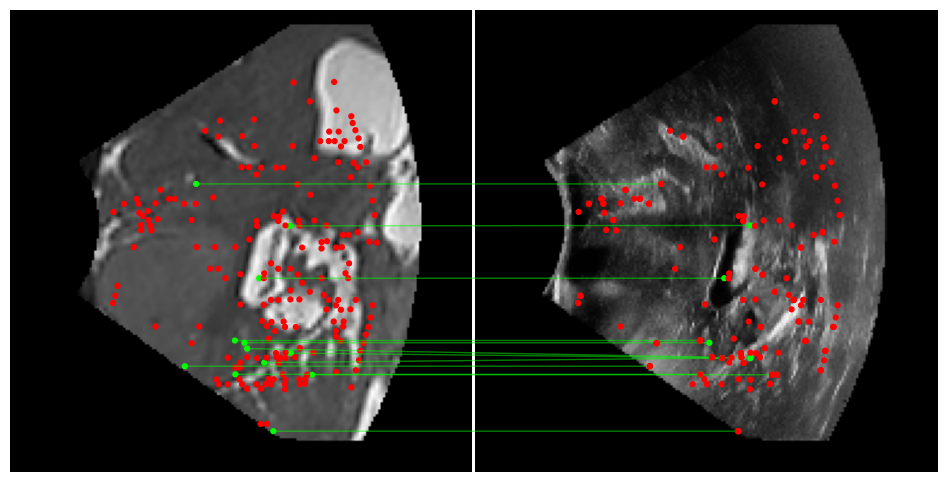

In [31]:
print(good_matches.shape)
print(bad_matches.shape)

plot_good_bad_matches(image1_np, image2_np, kpts1, kpts2, good_matches, bad_matches)

In [46]:
def load_data_for_slice(slice_index):
    slice_number = slice_index

    image1 = load_path_for_pytorch(f"data/mr_us/Case096/t2/{slice_number:03}.png", long_side,force_scale=True).to(device)
    image2 = load_path_for_pytorch(f"data/mr_us/Case096/us/{slice_number:03}.png", long_side,force_scale=True).to(device)
    
    masked_image1, binary_mask = isolate_green_and_mask_image(images/f"mr_us/Case096/t2/{slice_number:03}.png", images/f"mr_us/Case096/us_mask.png", long_side, device)

    extractor = SuperPoint(max_num_keypoints=200).eval().to(device)
    # image1 = image1.to(device)
    feats1 = extractor.extract(masked_image1)
    feats1 = rbd(feats1)
    kpts1 = feats1["keypoints"]
    
    # extractor = SuperPoint(max_num_keypoints=None).eval().to(device)
        
    # feats2 = extractor.extract(image2)
    # feats2 = rbd(feats2)
    # kpts2 = feats2["keypoints"]

    kpts2 = kpts1

    path_t2 = "data/mr_us/Case096/mind/Case096-t2.nii.gz"
    path_us = "data/mr_us/Case096/mind/Case096-us.nii.gz"
    
    mind_t2, mind_us = load_mind_descriptors(path_t2, path_us, slice_number)

    return image1, image2, kpts1, kpts2, mind_t2, mind_us


# image1, image2, kpts1, kpts2, mind_t2, mind_us = load_data_for_slice(slice_index)

In [48]:
import numpy as np

# Initialize lists to store TPR and FPR for all slices
tpr_list = []
fpr_list = []

for slice_index in range(0, 78):  # Assuming slice indexes are 0-based
    print(slice_index)
    # Load images, keypoints, and MIND descriptors for the current slice
    # Note: You'll need to implement `load_path_for_pytorch`, `isolate_green_and_mask_image`,
    # `load_mind_descriptors`, and other required functions to work with your specific data and setup.
    image1, image2, kpts1, kpts2, mind_t2, mind_us = load_data_for_slice(slice_index)

    # Perform matching and filtering as described
    matches, match_similarities = match_keypoints_with_mind(kpts1, kpts2, mind_t2, mind_us)
    filtered_matches, filtered_similarities = filter_matches_by_similarity(matches, match_similarities, threshold=0.8)
    
    # Evaluate matches to classify them as good or bad
    good_matches, bad_matches, good_match_percentage, bad_match_percentage = evaluate_matches(kpts1, kpts2, filtered_matches, margin=2)
    
    # Store TPR and FPR
    tpr_list.append(good_match_percentage)
    fpr_list.append(bad_match_percentage)

# Calculate average TPR and FPR across all slices
average_tpr = np.mean(tpr_list)
average_fpr = np.mean(fpr_list)

print(f"Average TPR: {average_tpr}%")
print(f"Average FPR: {average_fpr}%")


0


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


1


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


2


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


3


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


4


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


5


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


6


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


7


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


8


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


9


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


10


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


11


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


12


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


13


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


14


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


15


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


16


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


17


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


18


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


19


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


20


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


21


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


22


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


23


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


24


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


25


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


26


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


27


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


28


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


29


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


30


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


31


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


32


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


33


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


34


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


35


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


36


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


37


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


38


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


39


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


40


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


41


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


42


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


43


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


44


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


45


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


46


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


47


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


48


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


49


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


50


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


51


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


52


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


53


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


54


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


55


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


56


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


57


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


58


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


59


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


60


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


61


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


62


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


63


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


64


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


65


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


66


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


67


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


68


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


69


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


70


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


71


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


72


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


73


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


74


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


75


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


76


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


77


/tmp/ipykernel_12854/3428403937.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imread(path)


Average TPR: 3.621794871794872%
Average FPR: 96.37820512820512%
